In [58]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import jn

import jcamp as jc

In [76]:
#This cell contains my methods for linear interpolation, gaussian smoothing, (vertical) gaussian noise addition, and R/B shift

def interpolate_data_to_new_axis(data,originalAxis,newAxis, style = 2):
     # this method converts points in data from originalAxis to what their values would be at newAxis by interpoliation,
     # style determines how to fill in the points that are beyond the range of originalAxis, 0 fills them in with 0s, 1 fills them in with 1's, 2 filles them in with the last data point
     # any other value fills them in by interpolating the last point via the slope from the second to last point
    newData = np.zeros(newAxis.size, dtype=type(data[0]))
    counter = 0
    for i in range(newAxis.size):
        if newAxis[i]<originalAxis[0]:
            if( style==0):newData[i]=0
            elif(style==1):newData[i]=1
            elif(style==2):newData[i]=data[0]
            else: newData[i]=data[0]+(newAxis[i]-originalAxis[0])*(data[1]-data[0])/(originalAxis[1]-originalAxis[0])
        elif newAxis[i]>originalAxis[-1]:
            if( style==0):newData[i]=0
            elif(style==1):newData[i]=1
            elif(style==2):newData[i]=data[-1]
            else: newData[i]=data[-1]+(newAxis[i]-originalAxis[-1])*(data[-2]-data[-1])/(originalAxis[-2]-originalAxis[-1])
        elif newAxis[i]==originalAxis[counter]:
            newData[i] = data[counter]
        else:
            while originalAxis[counter]<newAxis[i]:
                counter+=1
            newData[i]=data[counter-1]+(newAxis[i]-originalAxis[counter-1])*(data[counter]-data[counter-1])/(originalAxis[counter]-originalAxis[counter-1])
    return(newData)


def R_B_shift( axis1, vel,ang): #This method gives a red/blue shifted axis (using wave numbers, and returns it in wave numbers), takes in velocity in m/s and angle in rad
    c=3e8
    zp1 = (1+vel*np.cos(ang)/c)/np.sqrt(1-vel*vel/(c*c))
    axis2=axis1/zp1
    return(axis2)

def R_B_shift_data(data, axis1, vel,ang):
    return(interpolate_data_to_new_axis(data,axis1,R_B_shift(axis1,vel,ang)))


def gaussian_smoothing(spectrum, noise_param): #this does gaussian smoothing
    #It takes in the spectrum and smooths according to the noise param, which is units of array

    shiftFactor=int(spectrum.size/2) #this is  the center of the array

    runningVect=np.zeros(spectrum.size) #this will be the output vector

    vect = np.array([np.exp(-(j-spectrum.size/2)*(j-spectrum.size/2)/(2*noise_param*noise_param))/np.sqrt(2*np.pi*noise_param*noise_param) for j in range(spectrum.size)])
    #^this sets up a gaussian distribution around the center of the array.

    for i in range(int(spectrum.size/2)):
        runningVect+=np.concatenate((vect[i:],vect[:i]),axis=0)*spectrum[shiftFactor-i]
    for i in range(int(spectrum.size/2)):
        runningVect+=np.concatenate((vect[-(i+1):],vect[:-(i+1)]),axis=0)*spectrum[shiftFactor+(i)]
    return(runningVect)




def vertical_noise_addition(spec,noise): #this adds vertical noise to the spectrum the noise is added as a gaussian centred at 0 with 
    #height given by 'noise', so 'noise' should be in the same units (and relative scale) as spectrum
    return(spec+np.random.normal(0,noise,spec.size))



def create_pseudo_comb(xAxis, spacing): #space between teeth = wn/tooth  delta_index is dx/di, wn=dx, so tooth = spacing*dx/di
    delta_index = 1.0*(xAxis[1]-xAxis[0])
    indexspacing = spacing/delta_index
    pscomb = np.zeros(len(xAxis))
    marker = 0
    for index in range( len(xAxis)):
        marker=marker+1
        if marker>indexspacing: 
            pscomb[index]=1
            marker=0
    return(pscomb)

def create_n_pseudo_comb(xAxis, spacing, noise): #space between teeth = wn/tooth  delta_index is dx/di, wn=dx, so tooth = spacing*dx/di
    delta_index = 1.0*(xAxis[1]-xAxis[0])
    indexspacing = spacing/delta_index
    pscomb = np.zeros(len(xAxis))
    marker = 0
    for index in range( len(xAxis)):
        marker=marker+1
        if marker>indexspacing: 
            pscomb[index]=1+np.random.normal(0,noise)
            marker=0
    return(pscomb)


def create_n_h_pseudo_comb(xAxis, spacing, noise, a,b): #space between teeth = wn/tooth  delta_index is dx/di, wn=dx, so tooth = spacing*dx/di
    delta_index = 1.0*(xAxis[1]-xAxis[0])
    indexspacing = spacing/delta_index
    #heights = np.random.random(len(xAxis))*(b-a)+a
    pscomb = np.zeros(len(xAxis))
    marker = 0
    for index in range( len(xAxis)):
        marker=marker+1
        if marker>indexspacing: 
            pscomb[index]=np.random.normal(np.random.random()*(b-a)+a,noise)
            marker=0
    return(pscomb)


def create_n_h_pseudo_combs(xAxis, spacing, noise, a,b, number): #space between teeth = wn/tooth  delta_index is dx/di, wn=dx, so tooth = spacing*dx/di
    delta_index = 1.0*(xAxis[1]-xAxis[0])
    indexspacing = spacing/delta_index
    heights = np.random.random(len(xAxis))*(b-a)+a
    combs=[]
    for i in range(number):
        pscomb = np.zeros(len(xAxis))
        marker = 0
        for index in range( len(xAxis)):
            marker=marker+1
            if marker>indexspacing: 
                pscomb[index]=np.random.normal(heights[index],noise)
                marker=0
        combs.append(pscomb)
    return(combs)

def create_n_h_pseudo_combs_no_spaceing(xAxis, noise, a,b, number): 
    heights = np.random.random(len(xAxis))*(b-a)+a
    combs=[]
    combs.append(np.ones(len(xAxis)))
    for i in range(number):
        #pscomb = np.zeros(len(xAxis))
        pscomb=heights+np.random.normal(0,noise,len(xAxis))
        combs.append(pscomb)
    return(combs)


In [80]:
# This cell contains methods for file conversion, and other helpful conversion stuff
# Specifically convert a JCamp object to numpy array, choosing the axis for multiple IR Files
# Reaxising the files, importing the files, saving the numpy files,
def jc_to_npy(list1):
    newlist = []#np.zeros((2,len(list1['x'])))
    newlist.append( list1['x'])
    newlist.append( list1['y'])
    return newlist


def choose_new_axis_multiple_IR(list_of_IR, axislength = 0): #the list of IR should be a list, each entry of which has two rows, the x axis and the y axis
    minIR=0 #should be below all the IR spectra values
    maxIR=40000 #should be above all IR spectra values
    lengthIR=0
    for index in range(len(list_of_IR)):
        if list_of_IR[index][0][0]>minIR: minIR=list_of_IR[index][0][0]
        if list_of_IR[index][0][-1]<maxIR: maxIR=list_of_IR[index][0][-1]
        if axislength==0 and len(list_of_IR[index][0])>lengthIR: lengthIR=len(list_of_IR[index][0])

    lIR=0
    if(not axislength==0): lIR=axislength
    else: lIR=2*lengthIR
    return(np.linspace(minIR,maxIR,lIR))


def reaxis_multiple_IR(list_of_IR, axislength = 0):#the list of IR should be a list, each entry of which has two rows, the x axis and the y axis
    #This returns an array with the first entry being the X axis and each subseuent entry being the IR data at that point on the axis.
    newX = choose_new_axis_multiple_IR(list_of_IR, axislength)
    new_IRs = []
    new_IRs.append(newX)
    for index in range(len(list_of_IR)):
        new_IRs.append(interpolate_data_to_new_axis(list_of_IR[index][1],list_of_IR[index][0],newX, 2))
    return(new_IRs)



def load_all_jc_data(numberofmolecules = 10): #the files should be called "_1.jdx" through "_numberofmolecules.jdx" will throw an error if the files dont exist.
    # by "throw an error" I mean it prints an error and skips that data file, but it will still pass all obtained data
    data = []
    for i in range(numberofmolecules):
        try:
            data.append(jc.jcamp_readfile("data\_"+str(i+1)+".jdx"))
        except FileNotFoundError:
            print("file "+ str(i+1) +" not found")
            continue

    return(data)



def convert_all_data(original_data):
    new_data=[]
    for index in range(len(original_data)):
        new_data.append(jc_to_npy(original_data[index]))
    
    return(new_data)


def load_jc_and_save_converted_IR(n_molec=10):
    data=convert_all_data(load_all_jc_data(n_molec))
    for index in range(len(data)):
        np.save("_"+str(index+1),data[index])


        
def load_all_npy_data(numberofmolecules = 10): #the files should be called "_1.npy" through "_numberofmolecules.npy" will throw an error if the files dont exist.
    # by "throw an error" I mean it prints an error and skips that data file, but it will still pass all obtained data
    data = []
    for i in range(numberofmolecules):
        try:
            data.append(np.load("_"+str(i+1)+".npy"))
        except FileNotFoundError:
            print("file "+ str(i+1) +" not found")
            continue

    return(data)







<>:42: SyntaxWarning: invalid escape sequence '\_'
<>:42: SyntaxWarning: invalid escape sequence '\_'
C:\Users\mtyle\AppData\Local\Temp\ipykernel_12824\2454085007.py:42: SyntaxWarning: invalid escape sequence '\_'
  data.append(jc.jcamp_readfile("data\_"+str(i+1)+".jdx"))


In [81]:
#this cell runs everything
#number_of_molecules =10
#number_of_trials_per_molecule = 100
#x_axis_resolution = 66171
#load_method = 0 #0 is from jcamp, 1 is from numpy file
#all_at_once = True
#machine_noise = False # This turns on the "precomb machine noise"

#noise_ranges=[0.05,x_axis_resolution/1000,3e5,0.05] # [0]: original gaussian noise, [1]: smoothing parameter, [2]: max speed parameter, [3]: machine noise parameter

'''
So This is how the data generation works (no combs in this file)
The first step is we load in all the data into the array which has 


'''
def create_data(noise_ranges, x_axis_resolution, number_of_trials_per_molecule=100, number_of_molecules=10, load_method=0, machine_noise=True, RARN=False):
    if RARN:
        if(load_method==0):
            if(machine_noise):
                IR_data_1 = reaxis_multiple_IR(convert_all_data(load_all_jc_data(number_of_molecules)),x_axis_resolution)
                IR_data_2 = []
                IR_data_2.append(IR_data_1[0])
                for index in range(len(IR_data_1)-1):
                    for index2 in range(number_of_trials_per_molecule):
                        IR_data_2.append( 
                            vertical_noise_addition(
                                sp.ndimage.gaussian_filter(
                                    vertical_noise_addition(
                                        R_B_shift_data(IR_data_1[index+1],IR_data_1[0],np.random.random()*noise_ranges[2],np.random.random()*2*np.pi),np.random.random()*noise_ranges[0]),noise_ranges[1]),np.random.random()*noise_ranges[3]))
            if(not machine_noise):
                IR_data_1 = reaxis_multiple_IR(convert_all_data(load_all_jc_data(number_of_molecules)),x_axis_resolution)
                IR_data_2 = []
                IR_data_2.append(IR_data_1[0])
                for index in range(len(IR_data_1)-1):
                    for index2 in range(number_of_trials_per_molecule):
                        IR_data_2.append( 
                            sp.ndimage.gaussian_filter(
                                vertical_noise_addition(
                                    R_B_shift_data(IR_data_1[index+1],IR_data_1[0],np.random.random()*noise_ranges[2],np.random.random()*2*np.pi)
                                    ,np.random.random()*noise_ranges[0])
                                    ,noise_ranges[1]))
            
        if(load_method==1):
            if(machine_noise):
                IR_data_1 = reaxis_multiple_IR(load_all_npy_data(number_of_molecules),x_axis_resolution)
                IR_data_2 = []
                IR_data_2.append(IR_data_1[0])
                for index in range(len(IR_data_1)-1):
                    for index2 in range(number_of_trials_per_molecule):
                        IR_data_2.append( 
                            vertical_noise_addition(
                                sp.ndimage.gaussian_filter(
                                    vertical_noise_addition(R_B_shift_data(IR_data_1[index+1],IR_data_1[0],np.random.random()*noise_ranges[2],np.random.random()*2*np.pi),np.random.random()*noise_ranges[0]),noise_ranges[1]),np.random.random()*noise_ranges[3]))
            if(not machine_noise):
                IR_data_1 = reaxis_multiple_IR(convert_all_data(load_all_jc_data(number_of_molecules)),x_axis_resolution)
                IR_data_2 = []
                IR_data_2.append(IR_data_1[0])
                for index in range(len(IR_data_1)-1):
                    for index2 in range(number_of_trials_per_molecule):
                        IR_data_2.append( 
                            sp.ndimage.gaussian_filter(
                                vertical_noise_addition(R_B_shift_data(IR_data_1[index+1],IR_data_1[0],np.random.random()*noise_ranges[2],np.random.random()*2*np.pi),np.random.random()*noise_ranges[0]),noise_ranges[1]))
    else:
        if(load_method==0):
            if(machine_noise):
                IR_data_1 = reaxis_multiple_IR(convert_all_data(load_all_jc_data(number_of_molecules)),x_axis_resolution)
                IR_data_2 = []
                IR_data_2.append(IR_data_1[0])
                for index in range(len(IR_data_1)-1):
                    for index2 in range(number_of_trials_per_molecule):
                        IR_data_2.append( 
                            vertical_noise_addition(
                                sp.ndimage.gaussian_filter(
                                    vertical_noise_addition(
                                        R_B_shift_data(IR_data_1[index+1],IR_data_1[0],np.random.random()*noise_ranges[2],np.random.random()*2*np.pi),
                                        noise_ranges[0]),
                                        noise_ranges[1]),
                                        noise_ranges[3]))
            if(not machine_noise):
                IR_data_1 = reaxis_multiple_IR(convert_all_data(load_all_jc_data(number_of_molecules)),x_axis_resolution)
                IR_data_2 = []
                IR_data_2.append(IR_data_1[0])
                for index in range(len(IR_data_1)-1):
                    for index2 in range(number_of_trials_per_molecule):
                        IR_data_2.append( 
                            sp.ndimage.gaussian_filter(
                                vertical_noise_addition(
                                    R_B_shift_data(IR_data_1[index+1],IR_data_1[0],np.random.random()*noise_ranges[2],np.random.random()*2*np.pi)
                                    ,noise_ranges[0])
                                    ,noise_ranges[1]))
            
        if(load_method==1):
            if(machine_noise):
                IR_data_1 = reaxis_multiple_IR(load_all_npy_data(number_of_molecules),x_axis_resolution)
                IR_data_2 = []
                IR_data_2.append(IR_data_1[0])
                for index in range(len(IR_data_1)-1):
                    for index2 in range(number_of_trials_per_molecule):
                        IR_data_2.append( 
                            vertical_noise_addition(
                                sp.ndimage.gaussian_filter(
                                    vertical_noise_addition(
                                        R_B_shift_data(IR_data_1[index+1],IR_data_1[0],np.random.random()*noise_ranges[2],np.random.random()*2*np.pi),
                                        noise_ranges[0]),
                                        noise_ranges[1]),
                                        noise_ranges[3]))
            if(not machine_noise):
                IR_data_1 = reaxis_multiple_IR(convert_all_data(load_all_jc_data(number_of_molecules)),x_axis_resolution)
                IR_data_2 = []
                IR_data_2.append(IR_data_1[0])
                for index in range(len(IR_data_1)-1):
                    for index2 in range(number_of_trials_per_molecule):
                        IR_data_2.append( 
                            sp.ndimage.gaussian_filter(
                                vertical_noise_addition(
                                    R_B_shift_data(IR_data_1[index+1],IR_data_1[0],np.random.random()*noise_ranges[2],np.random.random()*2*np.pi),
                                    noise_ranges[0]),
                                    noise_ranges[1]))
    return(IR_data_2)

# IR_data_2 is the array where the first coordinate is the x-axis data, the rest are the other data




In [82]:
print(IR_data_2[0][0],IR_data_2[0][-1],20*(IR_data_2[0][-1]-IR_data_2[0][0]))

463.438 3772.0 66171.23999999999


In [83]:
Final_noise_parameter = 0.01# 0.05

#pscombs1 = create_n_h_pseudo_combs_no_spaceing(IR_data_2[0], Final_noise_parameter, 0.2, 2, len(IR_data_2)-1)
#pscombs2 = create_n_h_pseudo_combs(IR_data_2[0], 0.5, Final_noise_parameter, 0.2, 2, len(IR_data_2)-1)


#IR_data_3=[]
#IR_data_3.append(IR_data_2[0])
#IR_data_4=[]
#IR_data_4.append(IR_data_2[0])

#for index in range(len(IR_data_2)-1):
#    IR_data_3.append(IR_data_2[index+1]*pscombs1[index])
#    IR_data_4.append(IR_data_2[index+1]*pscombs2[index])

#plt.plot(IR_data_3[0],IR_data_3[5])
x_axis_res=66171
SV = [x_axis_res/2000,x_axis_res/1000,x_axis_res/750,x_axis_res/500,x_axis_res/100]
N1 = [0.01,0.025, 0.05, 0.1, 0.25, 0.5]

for sv in SV:
    for n1 in N1:
        trial =np.array(create_data([0.05,sv,3e5,0], x_axis_res,100,10,0,False))
        output = []
        output= trial*np.array(create_n_h_pseudo_combs_no_spaceing(trial[0], n1, 0.1, 0.95, len(trial)-1))
        np.save("gaussian param "+ str(sv)+ "thermal param "+ str(n1),  output)
        
        


In [75]:
#np.save('7_23 0_5 spaced data',IR_data_4)
#np.save('7_23 1 spaced data',IR_data_3)
m = np.array([[2,3,4],[3,4,5],[4,3,5]])
print(m[1:])

[[3 4 5]
 [4 3 5]]


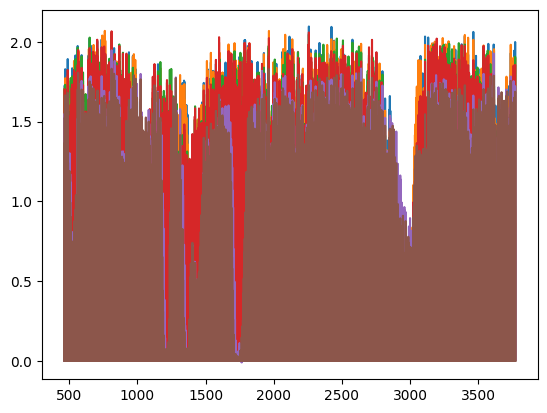

In [41]:
#This just plots 2 IR spectra for each molecule
for i in range(3):
    which_ir1 = int(np.random.random()*number_of_trials_per_molecule)
    which_ir2 = int(np.random.random()*number_of_trials_per_molecule)
    plt.plot(IR_data_3[0],IR_data_3[which_ir1+i*number_of_trials_per_molecule])
    plt.plot(IR_data_3[0],IR_data_3[which_ir2+i*number_of_trials_per_molecule])



In [51]:
np.save("_7_15 IR Data nonCombed", IR_data_2)